# Title : Analyzing Air Quality Index (AQI) Trends in a City

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings

In [2]:
# Supressing update warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("/content/AQIData.csv", encoding="cp1252")
data

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64015,67.0,25-05-15,Chhattisgarh,Bhilai,Chattisgarh Environment Conservation Board,"Residential, Rural and other Areas",7.0,17.0,73.0,NaN,"R.O., 5/32 Banglow Office Building, Bhilai",NaN,2015-05-25
64016,67.0,28-05-15,Chhattisgarh,Bhilai,Chattisgarh Environment Conservation Board,"Residential, Rural and other Areas",5.0,15.0,68.0,NaN,"R.O., 5/32 Banglow Office Building, Bhilai",NaN,2015-05-28
64017,67.0,01-06-15,Chhattisgarh,Bhilai,Chattisgarh Environment Conservation Board,"Residential, Rural and other Areas",6.0,16.0,74.0,NaN,"R.O., 5/32 Banglow Office Building, Bhilai",NaN,2015-06-01
64018,67.0,04-06-15,Chhattisgarh,Bhilai,Chattisgarh Environment Conservation Board,"Residential, Rural and other Areas",6.0,15.0,69.0,NaN,"R.O., 5/32 Banglow Office Building, Bhilai",NaN,2015-06-04


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64020 entries, 0 to 64019
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   stn_code                     41093 non-null  float64
 1   sampling_date                64020 non-null  object 
 2   state                        64020 non-null  object 
 3   location                     64020 non-null  object 
 4   agency                       40502 non-null  object 
 5   type                         63025 non-null  object 
 6   so2                          58428 non-null  float64
 7   no2                          62013 non-null  float64
 8   rspm                         60290 non-null  float64
 9   spm                          28357 non-null  float64
 10  location_monitoring_station  61418 non-null  object 
 11  pm2_5                        0 non-null      float64
 12  date                         64019 non-null  object 
dtypes: float64(6), o

In [6]:
# Cleaning up name changes
data.state = data.state.replace({'Uttaranchal':'Uttarakhand'})
data.state[data.location == "Jamshedpur"] = data.state[data.location == 'Jamshedpur'].replace({"Bihar":"Jharkhand"})

In [7]:
# Changing types to uniform format
types = {
    "Residential": "R",
    "Residential and others": "RO",
    "Residential, Rural and other Areas": "RRO",
    "Industrial Area": "I",
    "Industrial Areas": "I",
    "Industrial": "I",
    "Sensitive Area": "S",
    "Sensitive Areas": "S",
    "Sensitive": "S",
    np.nan: "RRO"
}

data.type = data.type.replace(types)
data.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,RRO,4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,I,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,RRO,6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,RRO,6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,I,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [8]:
# defining columns of importance, which shall be used reguarly
VALUE_COLS = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']

In [9]:
# invoking SimpleImputer to fill missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data[VALUE_COLS] = imputer.fit_transform(data[VALUE_COLS])

ValueError: Columns must be same length as key

In [ ]:
# checking to see if the dataset has any null values left over and the format
print(data.isnull().sum())
data.tail()

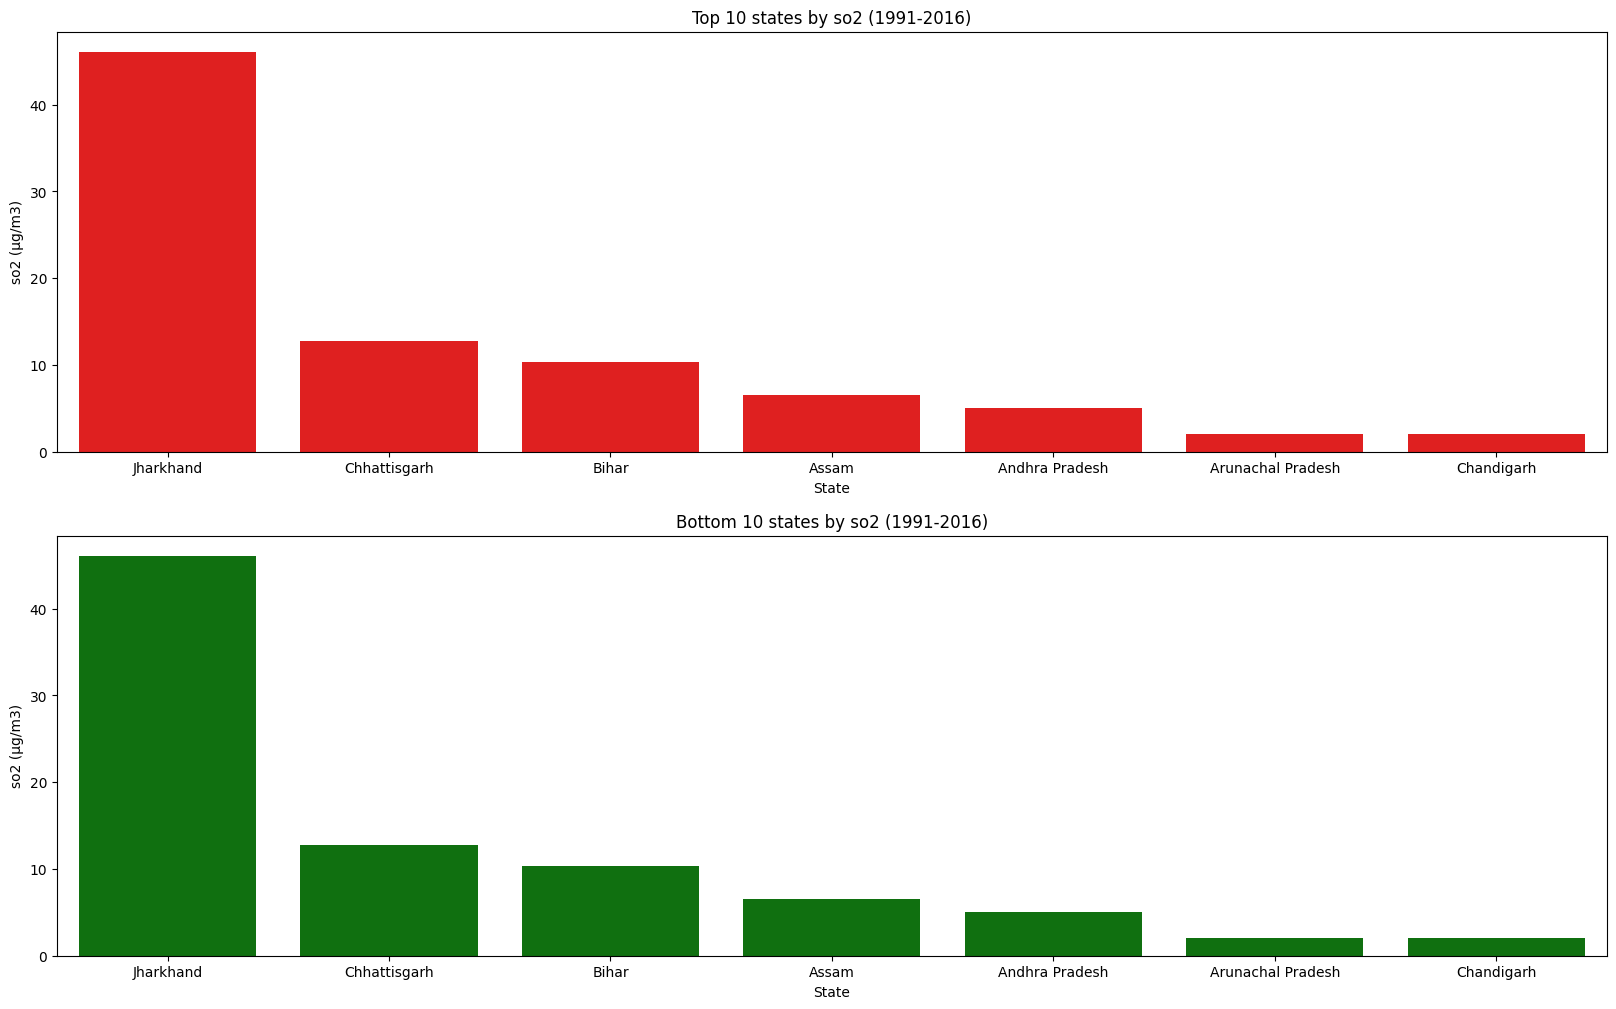

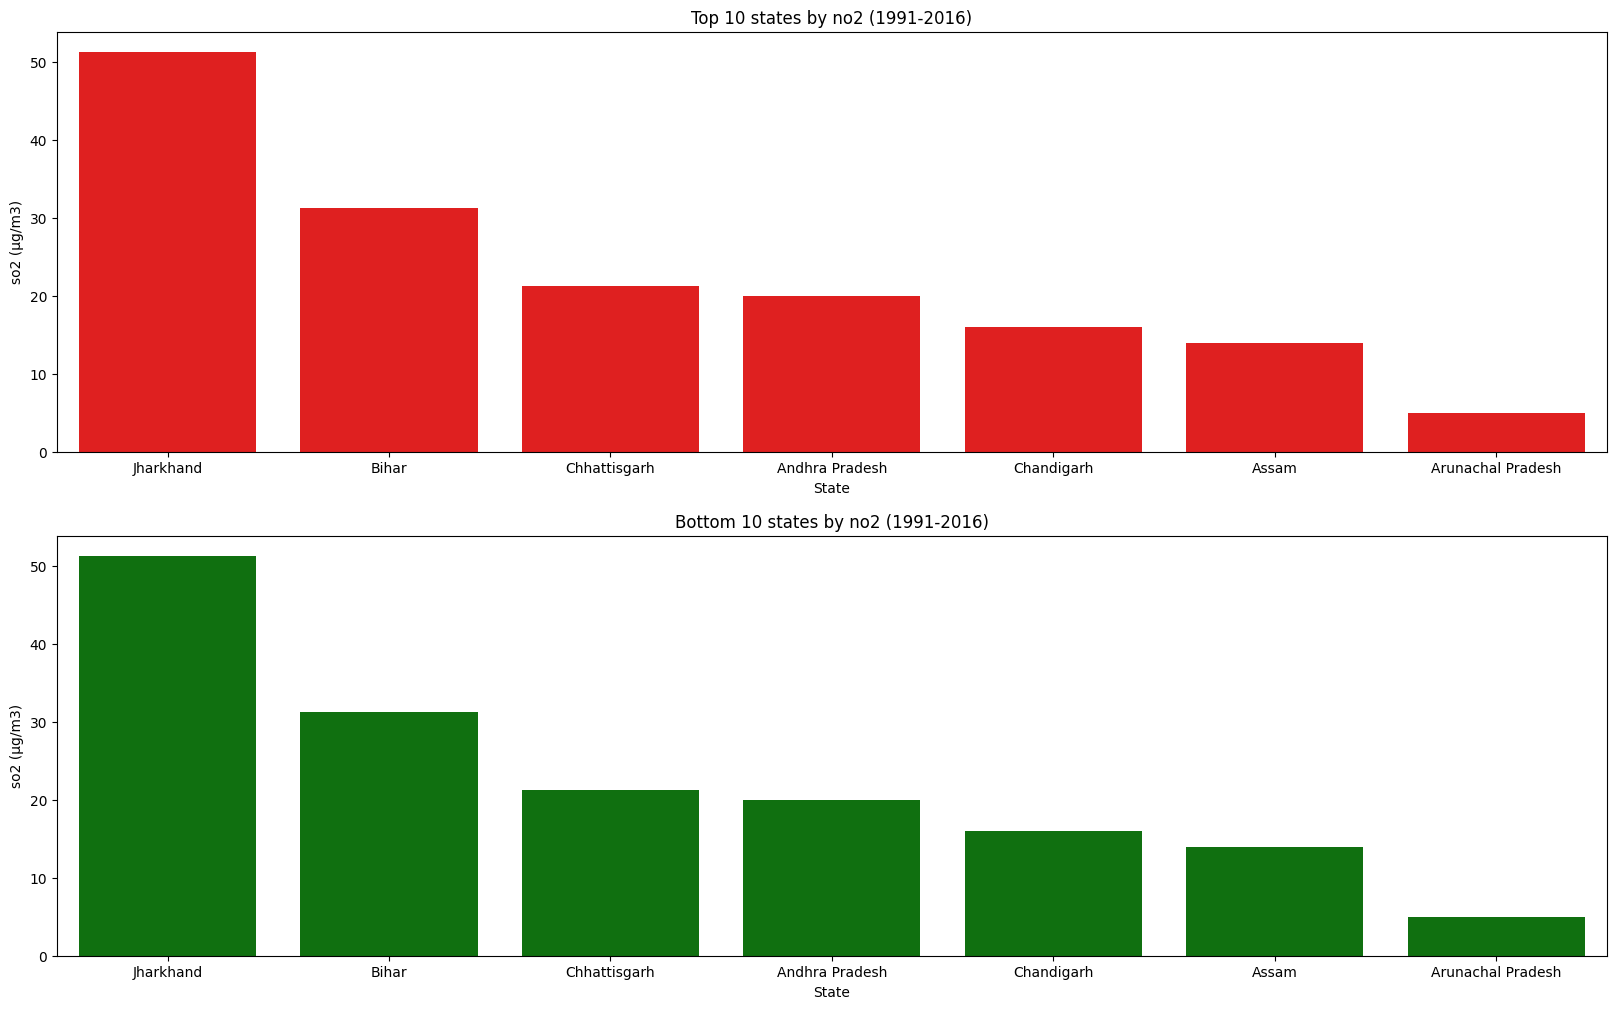

In [10]:
# Plotting highest and lowest ranking states
# defining a function to find and plot the top 10 and bottom 10 states for a given indicator (defaults to SO2)
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2,1, figsize=(20, 12))
    ind = data[[indicator, 'state']].groupby('state', as_index=False).median().sort_values(by=indicator,ascending=False)
    top10 = sns.barplot(x='state', y=indicator, data=ind[:10], ax=ax[0], color='red')
    top10.set_title("Top 10 states by {} (1991-2016)".format(indicator))
    top10.set_ylabel("so2 (µg/m3)")
    top10.set_xlabel("State")
    bottom10 = sns.barplot(x='state', y=indicator, data=ind[-10:], ax=ax[1], color='green')
    bottom10.set_title("Bottom 10 states by {} (1991-2016)".format(indicator))
    bottom10.set_ylabel("so2 (µg/m3)")
    bottom10.set_xlabel("State")

top_and_bottom_10_states("so2")
top_and_bottom_10_states("no2")

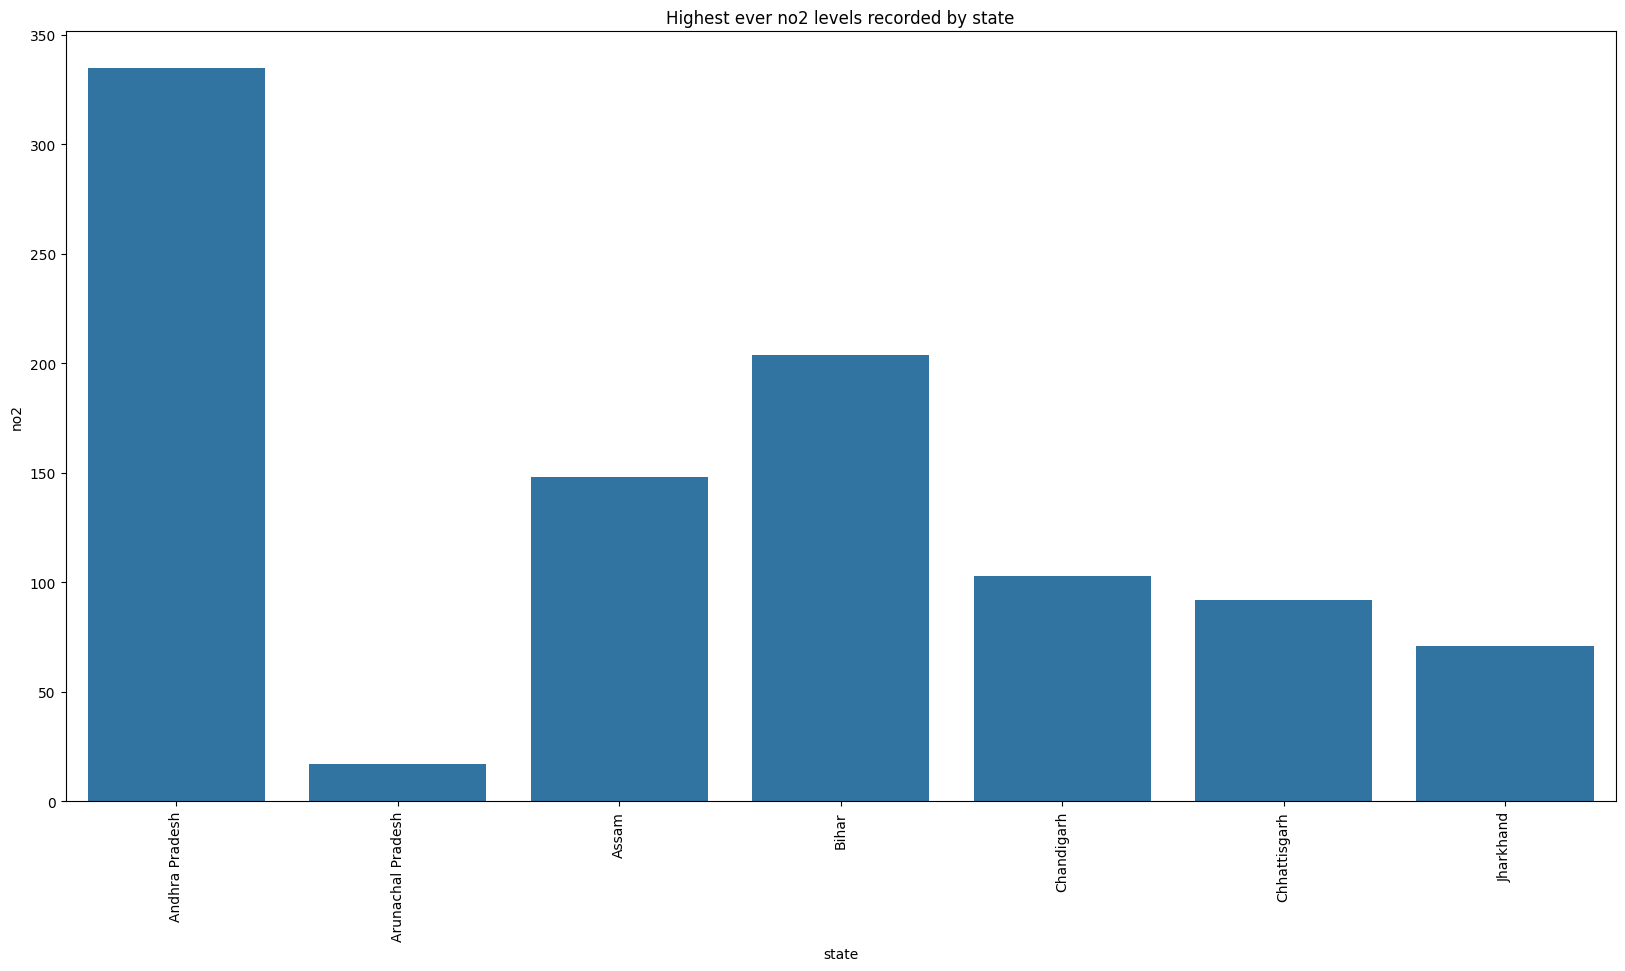

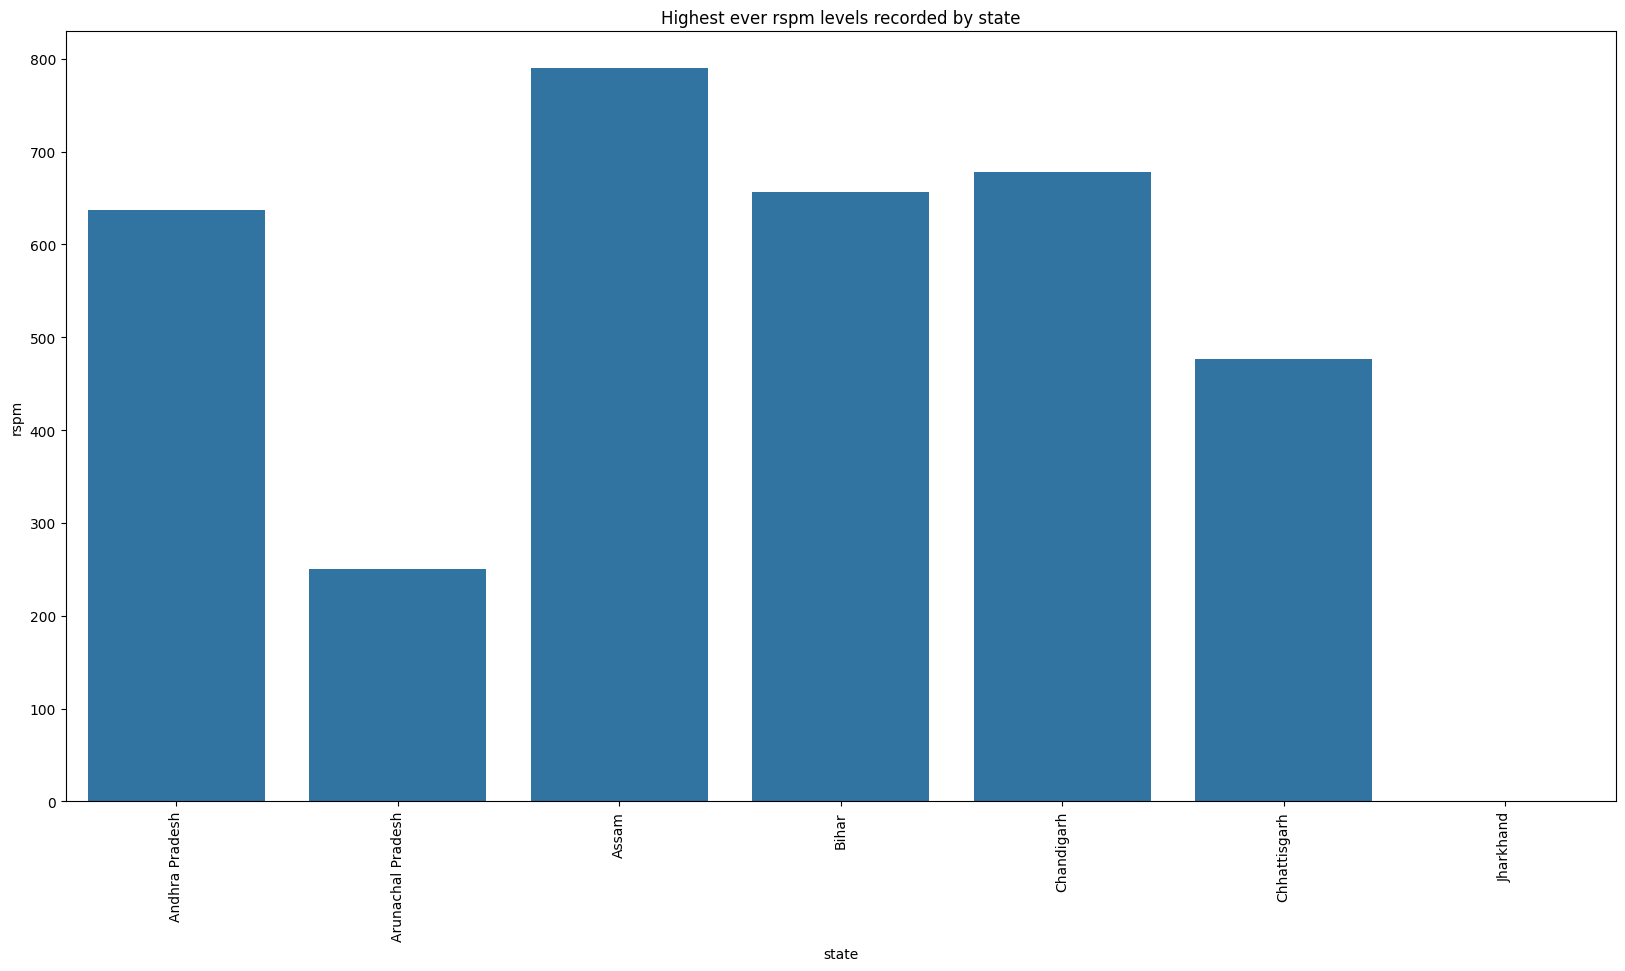

In [11]:
def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20, 10))
    # Select only relevant columns and apply max on the numeric column
    ind = data[['state', indicator]].groupby('state', as_index=False).max()

    # Plotting the results
    highest = sns.barplot(x='state', y=indicator, data=ind)
    highest.set_title(f"Highest ever {indicator} levels recorded by state")
    plt.xticks(rotation=90)
    plt.show()

# Test with specific indicators
highest_levels_recorded("no2")
highest_levels_recorded("rspm")


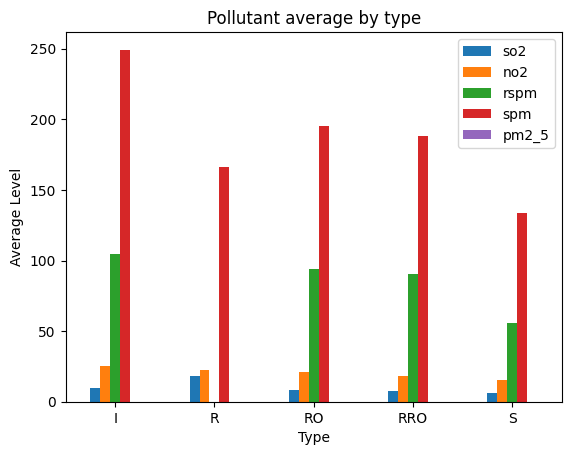

In [12]:
# Define function to plot pollutant averages by type
def type_avg(indicator=""):
    # Grouping by 'type' and calculating the mean for each indicator
    type_avg_df = data[VALUE_COLS + ['type']].groupby("type").mean()

    # Plot all indicators, with a legend
    type_avg_df.plot(kind='bar', legend=True)
    plt.title("Pollutant average by type")
    plt.xlabel("Type")
    plt.ylabel("Average Level")
    plt.xticks(rotation=0)  # Set x-axis labels to have no rotation
    plt.show()

# Example usage (remove 'indicator' parameter as we're plotting all)
type_avg()

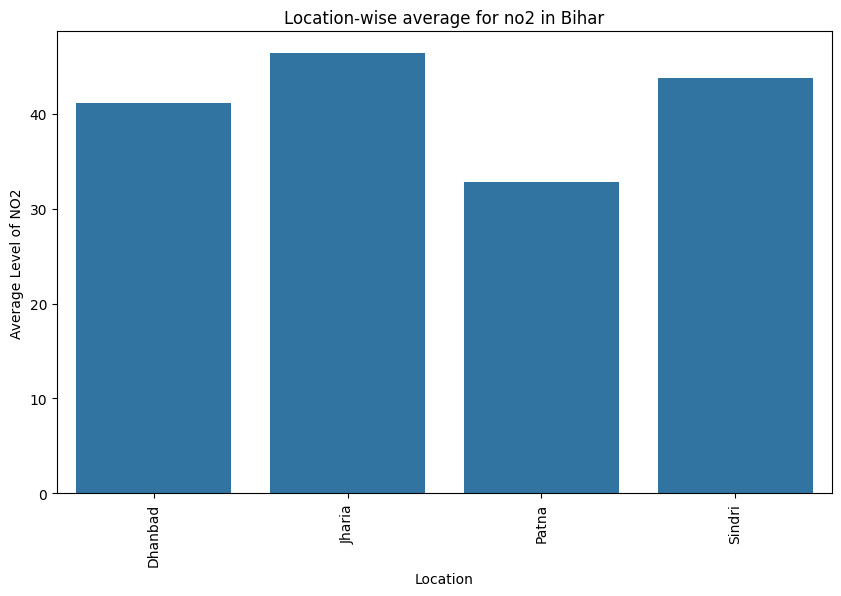

In [13]:
def location_avgs(state, indicator="so2"):
    # Grouping by 'state' and 'location' and calculating the mean for each indicator
    locs = data[VALUE_COLS + ['state', 'location']].groupby(['state', 'location']).mean()

    try:
        # Extracting the data for the specified state
        state_avgs = locs.loc[state].reset_index()

        # Plotting the data using Seaborn's barplot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='location', y=indicator, data=state_avgs)
        plt.title(f"Location-wise average for {indicator} in {state}")
        plt.xlabel("Location")
        plt.ylabel("Average Level of " + indicator.upper())
        plt.xticks(rotation=90)  # Rotate location names for better readability
        plt.show()

    except KeyError:
        print(f"State '{state}' not found in the dataset.")

# Example usage
location_avgs("Bihar", "no2")